In [1437]:
import os
import shutil
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import re
from collections import defaultdict

from pymatgen.core.structure import Structure
from pymatgen.io.cif import CifWriter

from get_weirdos_ver3 import apply_pbc, mic_eucledian_distance

# TO DO: 

fullness needs repairment for the dictionary of weirdos_appended!!!!

1) create folder manually with file of geometry 0 and 1 
2) copy manually the necessary file there

In [1438]:
path_geo_0 = [0, 1, 2, 3, 4, 5]
path_geo_1 = [0, 1, 2, 3]
path_geo_2 = [0, 1, 2, 3, 4]
path_geo_3 = [0, 1, 2, 3, 4, 5, 6, 7]
path_geo_4 = [0, 1, 2, 3, 4, 5]
path_geo_5 = [0, 1, 2, 3, 4, 5, 6, 7]
path_geo_6 = [0, 1, 2, 3, 4, 5, 6, 7]
path_geo_7 = [0, 1, 2, 3, 4, 5]
path_geo_8 = [0, 1, 2, 3]

In [1439]:
# def get_idxs_Li(file_path):
#     # Read the content of the file
#     with open(file_path, 'r') as f:
#         content = f.read()

#     # Use regular expressions to find the indices of "Li" entries
#     idxs_Li = [int(match.group(1)) for match in re.finditer(r'Li\s+Li(\d+)', content)]

#     return idxs_Li


def get_idx_coor_Li_dict(file_path):
    with open(file_path, 'r') as f:
        content = f.read()

    # Initialize a dictionary to store the data
    Li_idx_coor_dict = {}

    # Use regular expressions to extract Li indices and coordinates
    li_pattern = re.compile(r'Li\s+Li(\d+)\s+1\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)')
    matches = li_pattern.findall(content)

    # Iterate through the matches and populate the dictionary
    for match in matches:
        index = int(match[0])
        x = float(match[1])
        y = float(match[2])
        z = float(match[3])
        Li_idx_coor_dict[index] = (x, y, z)

    return Li_idx_coor_dict


def get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict):
    idx_coor_Li_idx_centroid_triad = defaultdict(list)
    for key, coor in idx_coor_Li_dict.items():
        idx_coor_Li_idx_centroid_triad_dict = {}    
        for key_triad, coor_triad in idx_coor_Li_dict_ref_triad.items():
            for coor_triad_component in coor_triad:
                distance = mic_eucledian_distance(coor_triad_component, coor)
                if distance == 0:
                    idx_coor_Li_idx_centroid_triad_dict['coor'] = coor
                    idx_coor_Li_idx_centroid_triad_dict['idx_triad'] = key_triad
                    idx_coor_Li_idx_centroid_triad_dict['centroid_triad'] = coor_triad[0]
                    # check if it's at 24g or 48h
                    if coor == coor_triad[0]:
                        idx_coor_Li_idx_centroid_triad_dict['structure'] = 24
                    else:
                        idx_coor_Li_idx_centroid_triad_dict['structure'] = 48                    
                    if key in idx_coor_Li_idx_centroid_triad:
                        idx_coor_Li_idx_centroid_triad[key].append(idx_coor_Li_idx_centroid_triad_dict)
                    else:
                        idx_coor_Li_idx_centroid_triad[key] = idx_coor_Li_idx_centroid_triad_dict
    return idx_coor_Li_idx_centroid_triad


# def get_24g_or_48h(idx_coor_Li_idx_centroid_triad):
#     # idxs_Li_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad.keys()]
#     idx_coor_Li_idx_centroid_triad = defaultdict(list)
#     for key, val in enumerate(idx_coor_Li_idx_centroid_triad):
#         if val['coor'] == val['centroid_triad']:


#     # idx_coor_Li_idx_centroid_triad = defaultdict(list)
#     # for key, coor in idx_coor_Li_dict.items():
#     #     idx_coor_Li_idx_centroid_triad_dict = {}    
#     #     for key_triad, coor_triad in idx_coor_Li_dict_ref_triad.items():
#     #         for coor_triad_component in coor_triad:
#     #             distance = mic_eucledian_distance(coor_triad_component, coor)
#     #             if distance == 0:
#     #                 idx_coor_Li_idx_centroid_triad_dict['coor'] = coor
#     #                 idx_coor_Li_idx_centroid_triad_dict['idx_triad'] = key_triad
#     #                 idx_coor_Li_idx_centroid_triad_dict['centroid_triad'] = coor_triad[0]                
#     #                 if key in idx_coor_Li_idx_centroid_triad:
#     #                     idx_coor_Li_idx_centroid_triad[key].append(idx_coor_Li_idx_centroid_triad_dict)
#     #                 else:
#     #                     idx_coor_Li_idx_centroid_triad[key] = idx_coor_Li_idx_centroid_triad_dict
#     return idx_coor_Li_idx_centroid_triad


def get_dist_ascending(idx_coor_Li_idx_centroid_triad):
    coors_Li_dist_structures = defaultdict(list)

    for Li_idx_temp1, val_temp1 in idx_coor_Li_idx_centroid_triad.items():
        coors_Li_dist_structures_dict = {}
        for Li_idx_temp2, val_temp2 in idx_coor_Li_idx_centroid_triad.items():
            distance = mic_eucledian_distance(val_temp1['coor'], val_temp2['coor'])
            coors_Li_dist_structures_dict['coors'] = (val_temp1['coor'], val_temp2['coor'])
            coors_Li_dist_structures_dict['dist'] = distance
            coors_Li_dist_structures_dict['structures'] = (val_temp1['structure'], val_temp2['structure'])

            key = (Li_idx_temp1, Li_idx_temp2)
            if key in coors_Li_dist_structures:
                coors_Li_dist_structures[key].append(coors_Li_dist_structures_dict)
            else:
                coors_Li_dist_structures[key] = coors_Li_dist_structures_dict

    sorted_coors_Li_dist_structures = dict(sorted(coors_Li_dist_structures.items(), key=lambda item: item[1]['dist']))
    dist_ascending = list({val['dist'] for idx, val in sorted_coors_Li_dist_structures.items()})

    return dist_ascending, sorted_coors_Li_dist_structures


def get_idx_coor_Li_idx_centroid_triad_w_closest_dist(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict):
    idx_coor_Li_idx_centroid_triad = defaultdict(list)
    distance_array = []
    for key, coor in idx_coor_Li_dict.items():
        idx_coor_Li_idx_centroid_triad_dict = {}    
        for key_triad, coor_triad in idx_coor_Li_dict_ref_triad.items():
            for coor_triad_component in coor_triad:
                distance = mic_eucledian_distance(coor_triad_component, coor)
                distance_array.append(distance)
                if distance == 0:
                    idx_coor_Li_idx_centroid_triad_dict['coor'] = coor
                    idx_coor_Li_idx_centroid_triad_dict['idx_triad'] = key_triad
                    idx_coor_Li_idx_centroid_triad_dict['centroid_triad'] = coor_triad[0]
                    # check if it's at 24g or 48h
                    if coor == coor_triad[0]:
                        idx_coor_Li_idx_centroid_triad_dict['structure'] = 24
                    else:
                        idx_coor_Li_idx_centroid_triad_dict['structure'] = 48                    
        distance_array_sorted = sorted(distance_array)
        distance_array_sorted_top3 = distance_array_sorted[1:4]
        idx_coor_Li_idx_centroid_triad_dict['dist_top3'] = distance_array_sorted_top3
        # idx_coor_Li_idx_centroid_triad_dict['dist'] = distance_array_sorted
        if key in idx_coor_Li_idx_centroid_triad:
            idx_coor_Li_idx_centroid_triad[key].append(idx_coor_Li_idx_centroid_triad_dict)
        else:
            idx_coor_Li_idx_centroid_triad[key] = idx_coor_Li_idx_centroid_triad_dict
    return idx_coor_Li_idx_centroid_triad


# def get_idx_coor_Li_idx_centroid_triad_w_closest_dist_weirdos_appended(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended, idxs_Li_not):
#     idx_coor_Li_idx_centroid_triad = defaultdict(list)
#     distance_array = []
#     for key, coor in idx_coor_Li_dict_weirdos_appended.items():
#         if key in idxs_Li_not:
#             idx_coor_Li_idx_centroid_triad_dict = {}    
#             for key_triad, coor_triad in idx_coor_Li_dict_ref_triad.items():
#                 for coor_triad_component in coor_triad:
#                     distance = mic_eucledian_distance(coor_triad_component, coor)
#                     distance_array.append(distance)  
#             distance_array_sorted = sorted(set(distance_array))
#             distance_array_sorted_top3 = distance_array_sorted[0:4]
#             idx_coor_Li_idx_centroid_triad_dict['dist_top3'] = distance_array_sorted_top3           
#         else:
#             idx_coor_Li_idx_centroid_triad_dict = {}    
#             for key_triad, coor_triad in idx_coor_Li_dict_ref_triad.items():
#                 for coor_triad_component in coor_triad:
#                     distance = mic_eucledian_distance(coor_triad_component, coor)
#                     distance_array.append(distance)
#                     if distance == 0:
#                         idx_coor_Li_idx_centroid_triad_dict['coor'] = coor
#                         idx_coor_Li_idx_centroid_triad_dict['idx_triad'] = key_triad
#                         idx_coor_Li_idx_centroid_triad_dict['centroid_triad'] = coor_triad[0]
#                         # check if it's at 24g or 48h
#                         if coor == coor_triad[0]:
#                             idx_coor_Li_idx_centroid_triad_dict['structure'] = 24
#                         else:
#                             idx_coor_Li_idx_centroid_triad_dict['structure'] = 48           
#         distance_array_sorted = sorted(set(distance_array))
#         distance_array_sorted_top3 = distance_array_sorted[0:4]
#         idx_coor_Li_idx_centroid_triad_dict['dist_top3'] = distance_array_sorted_top3
#         if key in idx_coor_Li_idx_centroid_triad:
#             idx_coor_Li_idx_centroid_triad[key].append(idx_coor_Li_idx_centroid_triad_dict)
#         else:
#             idx_coor_Li_idx_centroid_triad[key] = idx_coor_Li_idx_centroid_triad_dict
#     return idx_coor_Li_idx_centroid_triad


def get_idx_coor_Li_idx_centroid_triad_w_closest_dist_weirdos_appended(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended, idxs_Li_not):
    idx_coor_Li_idx_centroid_triad_weirdos_appended = defaultdict(list)
    distance_array = []
    for key, coor in idx_coor_Li_dict_weirdos_appended.items():
        # if key in idxs_Li_not:
        #     idx_coor_Li_idx_centroid_triad_dict = {}    
        #     for key_triad, coor_triad in idx_coor_Li_dict_ref_triad.items():
        #         for coor_triad_component in coor_triad:
        #             distance = mic_eucledian_distance(coor_triad_component, coor)
        #             distance_array.append(distance)  
        #     distance_array_sorted = sorted(set(distance_array))
        #     distance_array_sorted_top3 = distance_array_sorted[0:4]
        #     idx_coor_Li_idx_centroid_triad_dict['dist_top3'] = distance_array_sorted_top3  
        #     if key in idx_coor_Li_idx_centroid_triad_weirdos_appended:
        #         idx_coor_Li_idx_centroid_triad_weirdos_appended[key].append(idx_coor_Li_idx_centroid_triad_dict)
        #     else:
        #         idx_coor_Li_idx_centroid_triad_weirdos_appended[key] = idx_coor_Li_idx_centroid_triad_dict         
        # else:
        idx_coor_Li_idx_centroid_triad_dict = {}    
        for key_triad, coor_triad in idx_coor_Li_dict_ref_triad.items():
            for coor_triad_component in coor_triad:
                distance = mic_eucledian_distance(coor_triad_component, coor)
                distance_array.append(distance)
                if distance == 0:
                    idx_coor_Li_idx_centroid_triad_dict['coor'] = coor
                    idx_coor_Li_idx_centroid_triad_dict['idx_triad'] = key_triad
                    idx_coor_Li_idx_centroid_triad_dict['centroid_triad'] = coor_triad[0]
                    # check if it's at 24g or 48h
                    if coor == coor_triad[0]:
                        idx_coor_Li_idx_centroid_triad_dict['structure'] = 24
                    else:
                        idx_coor_Li_idx_centroid_triad_dict['structure'] = 48           
        distance_array_sorted = sorted(set(distance_array))
        distance_array_sorted_top3 = distance_array_sorted[0:4]
        # idx_coor_Li_idx_centroid_triad_dict['dist_top3'] = distance_array_sorted_top3
        if key in idx_coor_Li_idx_centroid_triad_weirdos_appended:
            idx_coor_Li_idx_centroid_triad_weirdos_appended[key].append(idx_coor_Li_idx_centroid_triad_dict)
        else:
            idx_coor_Li_idx_centroid_triad_weirdos_appended[key] = idx_coor_Li_idx_centroid_triad_dict
    return idx_coor_Li_idx_centroid_triad_weirdos_appended

# find the distance of Li between CONCTAR_pymatgen of each path wrt path 0

In [1440]:
def get_distance_wrtpath0_and_litoli(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename):
    # df_coor = pd.DataFrame()
    df_distance = pd.DataFrame()
    coor_Li_ref = []
    df_dist_litoli = pd.DataFrame()

    df_dist_litoli["dist"] = None

    # col_xyz_coor = "xyz_coor"

    # df_coor[col_xyz_coor] = None

    if geo == 0:
        path_geo = path_geo_0
    elif geo == 1:
        path_geo = path_geo_1
    elif geo == 2:
        path_geo = path_geo_2
    elif geo == 3:
        path_geo = path_geo_3
    elif geo == 4:
        path_geo = path_geo_4
    elif geo == 5:
        path_geo = path_geo_5
    elif geo == 6:
        path_geo = path_geo_6
    elif geo == 7:
        path_geo = path_geo_7
    elif geo == 8:
        path_geo = path_geo_8

    file_ref = f"{geo}_0_{var_filename_ref}.cif"
    file_path_ref = os.path.join(destination_directory, file_ref)

    structure_ref = Structure.from_file(file_path_ref)

    for idx, coor in enumerate(structure_ref):
        if coor.species_string == "Li":
            coor_Li_ref.append(coor.frac_coords)

    for i in path_geo:
        coor_Li = []
        file = f"{geo}_{i}_{var_filename}.cif"
        file_path = os.path.join(destination_directory, file)
    
        structure = Structure.from_file(file_path)
        # frac_coor = structure.frac_coords

        for idx, coor in enumerate(structure):
            if coor.species_string == "Li":
                coor_Li.append(coor.frac_coords)        
            
        # df_coor.at[i, col_xyz_coor] = coor_Li#

        coors_Li_dist_structures = defaultdict(list)

        for j in range(len(coor_Li)):
            # df_distance.at[i, f"{j}"] = None  

            distance = mic_eucledian_distance(coor_Li_ref[j], coor_Li[j])

            df_distance.at[i, f"{j}"] = distance

            diameter_24g48h = max_mapping_radius * 2
            if distance < diameter_24g48h and i != 0:
                print(f"path: {i}, Li: {j}, distance: {distance}")

            coors_Li_dist_structures_dict = {}
            
            for k in range(len(coor_Li)):

                distance_litoli = mic_eucledian_distance(coor_Li[j], coor_Li[k])

                coors_Li_dist_structures_dict['coors'] = (coor_Li[j], coor_Li[k])
                coors_Li_dist_structures_dict['dist'] = distance_litoli
                # coors_Li_dist_structures_dict['structures'] = (val_temp1['structure'], val_temp2['structure'])

                key = (j, k)
                if key in coors_Li_dist_structures:
                    coors_Li_dist_structures[key].append(coors_Li_dist_structures_dict)
                else:
                    coors_Li_dist_structures[key] = coors_Li_dist_structures_dict               

        sorted_coors_Li_dist_structures = dict(sorted(coors_Li_dist_structures.items(), key=lambda item: item[1]['dist']))
        dist_ascending = list({val['dist'] for idx, val in sorted_coors_Li_dist_structures.items()})

        df_dist_litoli.at[i, "dist"] = dist_ascending[1:6]

    return df_distance, df_dist_litoli

In [1441]:
def get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_ref_24, idx_coor_Li_dict_ref_72):
    idxs_Li_ref_24 = list(idx_coor_Li_dict_ref_24.keys())
    idxs_Li_ref_72 = list(idx_coor_Li_dict_ref_72.keys())

    idx_coor_Li_dict_ref_triad = defaultdict(list)

    for key_72, coor_72 in idx_coor_Li_dict_ref_72.items():
        for key_24, coor_24 in idx_coor_Li_dict_ref_24.items():
            distance = mic_eucledian_distance(coor_72, coor_24)
            if distance == 0:
                idx_coor_Li_dict_ref_triad[key_24].append(coor_72)

    for key_72, coor_72 in idx_coor_Li_dict_ref_72.items():
        for key_24, coor_24 in idx_coor_Li_dict_ref_24.items():
            distance = mic_eucledian_distance(coor_72, coor_24)
            if distance <= 0.086399 and distance != 0:                      # to edit this number
                idx_coor_Li_dict_ref_triad[key_24].append(coor_72)
    return idx_coor_Li_dict_ref_triad

In [1442]:
def get_distance_wrtpath0(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename):
    # df_coor = pd.DataFrame()
    df_distance = pd.DataFrame()
    coor_Li_ref = []

    # col_xyz_coor = "xyz_coor"

    # df_coor[col_xyz_coor] = None

    if geo == 0:
        path_geo = path_geo_0
    elif geo == 1:
        path_geo = path_geo_1
    elif geo == 2:
        path_geo = path_geo_2
    elif geo == 3:
        path_geo = path_geo_3
    elif geo == 4:
        path_geo = path_geo_4
    elif geo == 5:
        path_geo = path_geo_5
    elif geo == 6:
        path_geo = path_geo_6
    elif geo == 7:
        path_geo = path_geo_7
    elif geo == 8:
        path_geo = path_geo_8

    file_ref = f"{geo}_0_{var_filename_ref}.cif"
    file_path_ref = os.path.join(destination_directory, file_ref)

    structure_ref = Structure.from_file(file_path_ref)

    for idx, coor in enumerate(structure_ref):
        if coor.species_string == "Li":
            coor_Li_ref.append(coor.frac_coords)

    for i in path_geo:
        coor_Li = []
        file = f"{geo}_{i}_{var_filename}.cif"
        file_path = os.path.join(destination_directory, file)
    
        structure = Structure.from_file(file_path)
        # frac_coor = structure.frac_coords

        for idx, coor in enumerate(structure):
            if coor.species_string == "Li":
                coor_Li.append(coor.frac_coords)        
            
        # df_coor.at[i, col_xyz_coor] = coor_Li

        for j in range(len(coor_Li)):
            # df_distance.at[i, f"{j}"] = None  

            distance = mic_eucledian_distance(coor_Li_ref[j], coor_Li[j])

            df_distance.at[i, f"{j}"] = distance

            diameter_24g48h = max_mapping_radius * 2
            if distance < diameter_24g48h and i != 0:
                print(f"path: {i}, Li: {j}, distance: {distance}")

    return df_distance


def plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs):

    diameter_24g48h = max_mapping_radius * 2

    x = range(len(df_distance))

    fig = plt.figure()
    ax = plt.subplot(111)

    lines = []

    for i in range(len(df_distance.columns)):
        if Li_idxs == "all" or i in Li_idxs:
            # # i = i
            line, = ax.plot(x, df_distance[f"{i}"], label=f"{i}")
            lines.append(line)
            # label = f"{i}" if Li_idxs == "all" else None
            # line, = ax.plot(x, df_distance[f"{i}"], label=label)
            lines.append(line)

        # if type(Li_idxs) == list:
        #     for j in Li_idxs:
        #         if i == j:
        #             line, = ax.plot(x, df_distance[f"{i}"], label=f"{i}")
        #             lines.append(line)

    ax.axhline(y=diameter_24g48h, color='b', linestyle=':', label=f'd_24g48h = {diameter_24g48h:.3f}')

    plt.title(f"Geometry {geo} with d={diameter_24g48h}")

    # Shrink current axis's height by 10% on the bottom
        # source: https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    handles, labels = ax.get_legend_handles_labels()

    ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.05),
            fancybox=True, shadow=True, ncol=5)

    plt.show()

In [1443]:
def get_distance_triads_wrtpath0(destination_directory, geo, var_filename, filename_ref_72):
    # df_coor = pd.DataFrame()
    df_distance = pd.DataFrame()
    df_ratio = pd.DataFrame()
    # coor_Li_ref = []

    # col_xyz_coor = "xyz_coor"

    # df_coor[col_xyz_coor] = None

    if geo == 0:
        path_geo = path_geo_0
    elif geo == 1:
        path_geo = path_geo_1
    elif geo == 2:
        path_geo = path_geo_2
    elif geo == 3:
        path_geo = path_geo_3
    elif geo == 4:
        path_geo = path_geo_4
    elif geo == 5:
        path_geo = path_geo_5
    elif geo == 6:
        path_geo = path_geo_6
    elif geo == 7:
        path_geo = path_geo_7
    elif geo == 8:
        path_geo = path_geo_8

    file_ref_24 = f"{geo}_0_{var_filename}.cif"
    file_path_ref_24 = os.path.join(destination_directory, file_ref_24)

    file_ref_72 = f"{filename_ref_72}.cif"
    file_path_ref_72 = os.path.join(destination_directory, file_ref_72)


    idx_coor_Li_dict_ref_24 = get_idx_coor_Li_dict(file_path_ref_24)    # key is the pointer to 24
    idx_coor_Li_dict_ref_72 = get_idx_coor_Li_dict(file_path_ref_72)    # key is the pointer to 24

    idx_coor_Li_dict_ref_triad = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_ref_24, idx_coor_Li_dict_ref_72)
    # idxs_Li_ref_24 = list(idx_coor_Li_dict_ref_24.keys())
    # idxs_Li_ref_72 = list(idx_coor_Li_dict_ref_72.keys())

    for i in path_geo:
        # coor_Li = []
        file = f"{geo}_{i}_{var_filename}.cif"
        file_path = os.path.join(destination_directory, file)

        idx_coor_Li_dict = get_idx_coor_Li_dict(file_path)
        # idxs_Li = list(idx_coor_Li_dict.keys())

        # # idx_coor_Li_triad_belonging_initial = defaultdict(list)
        # # idx_coor_Li_triad_belonging_initial_centroid = defaultdict(list)

        ### does the numeration of Li is important?
        ### 1) check which triad it does belong to initially

        idx_coor_Li_idx_centroid_triad_ref = get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_ref_24)
        idx_coor_Li_idx_centroid_triad = get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict)
        idxs_Li_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad.keys()]

        ## get ratio of 24:48
        counter_48 = 0
        for Li_idx, val in idx_coor_Li_idx_centroid_triad.items():
            # print(mic_eucledian_distance(val['coor'], val['centroid_triad']))
            if val['structure'] == 48:
                counter_48 = counter_48 + 1
        # print(f"path {i} has ratio of 48 of: {counter_48/len(idx_coor_Li_idx_centroid_triad)}")
        df_ratio.at[i, "ratio of 48"] = counter_48/len(idx_coor_Li_idx_centroid_triad)

        for j in idxs_Li_dict:
            # df_distance.at[i, f"{j}"] = None  

            distance = mic_eucledian_distance(idx_coor_Li_idx_centroid_triad_ref[j]['centroid_triad'], idx_coor_Li_idx_centroid_triad[j]["centroid_triad"])

            df_distance.at[i, f"{j}"] = distance

            if distance == 0 and i != 0:
                print(f"path: {i}, Li: {j}, distance: {distance}")

    return df_distance, df_ratio

In [1444]:
def get_triads_movement(destination_directory, geo, var_filename, filename_ref_72):
    # df_coor = pd.DataFrame()
    df_triad = pd.DataFrame()
    df_ratio = pd.DataFrame()
    df_dist = pd.DataFrame()

    df_dist["dist"] = None
    # coor_Li_ref = []

    # col_xyz_coor = "xyz_coor"

    # df_coor[col_xyz_coor] = None

    if geo == 0:
        path_geo = path_geo_0
    elif geo == 1:
        path_geo = path_geo_1
    elif geo == 2:
        path_geo = path_geo_2
    elif geo == 3:
        path_geo = path_geo_3
    elif geo == 4:
        path_geo = path_geo_4
    elif geo == 5:
        path_geo = path_geo_5
    elif geo == 6:
        path_geo = path_geo_6
    elif geo == 7:
        path_geo = path_geo_7
    elif geo == 8:
        path_geo = path_geo_8

    file_ref_24 = f"{geo}_0_{var_filename}.cif"
    file_path_ref_24 = os.path.join(destination_directory, file_ref_24)

    file_ref_72 = f"{filename_ref_72}.cif"
    file_path_ref_72 = os.path.join(destination_directory, file_ref_72)


    idx_coor_Li_dict_ref_24 = get_idx_coor_Li_dict(file_path_ref_24)    # key is the pointer to 24
    idx_coor_Li_dict_ref_72 = get_idx_coor_Li_dict(file_path_ref_72)    # key is the pointer to 24

    idx_coor_Li_dict_ref_triad = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_ref_24, idx_coor_Li_dict_ref_72)
    # idxs_Li_ref_24 = list(idx_coor_Li_dict_ref_24.keys())
    # idxs_Li_ref_72 = list(idx_coor_Li_dict_ref_72.keys())

    for i in path_geo:
        # coor_Li = []
        file = f"{geo}_{i}_{var_filename}.cif"
        file_path = os.path.join(destination_directory, file)

        idx_coor_Li_dict = get_idx_coor_Li_dict(file_path)
        # idxs_Li = list(idx_coor_Li_dict.keys())

        # # idx_coor_Li_triad_belonging_initial = defaultdict(list)
        # # idx_coor_Li_triad_belonging_initial_centroid = defaultdict(list)

        ### does the numeration of Li is important?
        ### 1) check which triad it does belong to initially

        idx_coor_Li_idx_centroid_triad_ref = get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_ref_24)
        idx_coor_Li_idx_centroid_triad = get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict)
        idxs_Li_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad.keys()]

        ## get ratio of 24:48
        counter_48 = 0
        for Li_idx, val in idx_coor_Li_idx_centroid_triad.items():
            # print(mic_eucledian_distance(val['coor'], val['centroid_triad']))
            if val['structure'] == 48:
                counter_48 = counter_48 + 1
        # print(f"path {i} has ratio of 48 of: {counter_48/len(idx_coor_Li_idx_centroid_triad)}")
        df_ratio.at[i, "ratio of 48"] = counter_48/len(idx_coor_Li_idx_centroid_triad)

        ## get li-to-li-distance 
        dist_ascending, sorted_coors_Li_dist_structures = get_dist_ascending(idx_coor_Li_idx_centroid_triad)
        # print(dist_ascending)
        df_dist.at[i, "dist"] = dist_ascending[1:6]

        for j in idxs_Li_dict:
            # df_triad.at[i, f"{j}"] = None  

            triad = idx_coor_Li_idx_centroid_triad[j]["idx_triad"]

            df_triad.at[i, f"{j}"] = triad

            if triad == df_triad.at[0, f"{j}"] and i != 0:
                print(f"path: {i}, Li: {j}, triad: {triad}")

    return df_triad, df_ratio, df_dist, sorted_coors_Li_dist_structures

# find the distance of Li between CONCTAR_pymatgen of each path wrt path 0

# CONTCAR to CONTCAR comparison

## max_mapping_radius = 0.043

Path 1: idx0_weirdos_Li = [[9, 21]]

Path 3: idx0_weirdos_Li = [[3, 12]

In [1445]:
max_mapping_radius = 0.09
var_filename_ref = "CONTCAR_pymatgen"
var_filename = "CONTCAR_pymatgen"
destination_directory = f"restructure_{max_mapping_radius}/"

path: 1, Li: 0, distance: 0.11578400937250619
path: 1, Li: 1, distance: 0.08766513745679583
path: 1, Li: 2, distance: 0.09990335210137304
path: 1, Li: 3, distance: 0.056500655283850426
path: 1, Li: 4, distance: 0.0852143576369904
path: 1, Li: 5, distance: 0.11763775969572185
path: 1, Li: 6, distance: 0.08025740165519497
path: 1, Li: 7, distance: 0.1240398165500018
path: 1, Li: 8, distance: 0.08498695200005822
path: 1, Li: 9, distance: 0.043198802610536574
path: 1, Li: 10, distance: 0.1092843089779636
path: 1, Li: 11, distance: 0.11981611761306617
path: 1, Li: 12, distance: 0.0743537249064235
path: 1, Li: 13, distance: 0.05633813660843693
path: 1, Li: 14, distance: 0.02783360861526403
path: 1, Li: 15, distance: 0.09485115692137289
path: 1, Li: 16, distance: 0.0892534459949559
path: 1, Li: 17, distance: 0.10649854347116208
path: 1, Li: 18, distance: 0.09296673287737124
path: 1, Li: 19, distance: 0.09616597851530806
path: 1, Li: 20, distance: 0.10414093737920592
path: 1, Li: 21, distance:

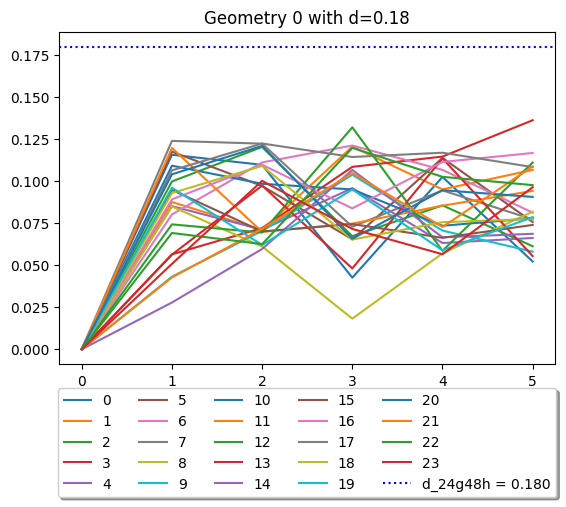

In [1446]:
geo = 0
df_distance, df_dist_litoli = get_distance_wrtpath0_and_litoli(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

In [1447]:
df_dist_litoli

,dist
0,"[0.32020424844767115, 0.32200996519637365, 0.3..."
1,"[0.28174655483728095, 0.33435749685000876, 0.3..."
2,"[0.33526411261709804, 0.3376784872569985, 0.27..."
3,"[0.2683907706313261, 0.32640790264073966, 0.31..."
4,"[0.2729724159423391, 0.33125200797903376, 0.32..."
5,"[0.3248947155760811, 0.3505449975953042, 0.339..."


In [1448]:
df_dist_litoli.to_excel("df_dist_litoli_0.xlsx")  

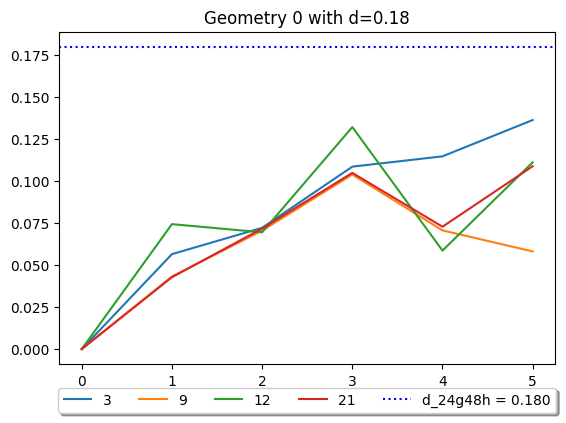

In [1449]:
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = [9, 21, 3, 12])

path: 1, Li: 0, distance: 0.08535709687414983
path: 1, Li: 1, distance: 0.06879266467894743
path: 1, Li: 2, distance: 0.11804832763085629
path: 1, Li: 3, distance: 0.045165596697230685
path: 1, Li: 4, distance: 0.08285926420872494
path: 1, Li: 5, distance: 0.12337971133797529
path: 1, Li: 6, distance: 0.11914440773029426
path: 1, Li: 7, distance: 0.0815569231436363
path: 1, Li: 8, distance: 0.06938074757695317
path: 1, Li: 9, distance: 0.06306752659881708
path: 1, Li: 10, distance: 0.10225207363394735
path: 1, Li: 11, distance: 0.09489384851875546
path: 1, Li: 12, distance: 0.04799621208339365
path: 1, Li: 13, distance: 0.0959915985430126
path: 1, Li: 14, distance: 0.06031828923031895
path: 1, Li: 15, distance: 0.0702536258325626
path: 1, Li: 16, distance: 0.09652983540571065
path: 1, Li: 17, distance: 0.11720477729941474
path: 1, Li: 18, distance: 0.10107197534800878
path: 1, Li: 19, distance: 0.06360417531530928
path: 1, Li: 20, distance: 0.09477113371869987
path: 1, Li: 21, distance

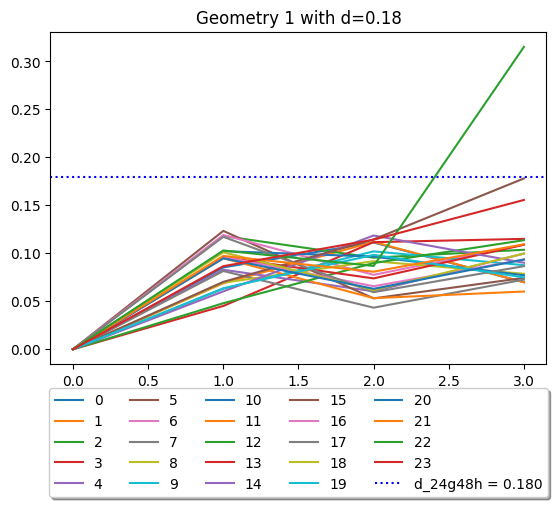

In [1450]:
geo = 1
df_distance, df_dist_litoli = get_distance_wrtpath0_and_litoli(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

In [1451]:
df_dist_litoli

,dist
0,"[0.31999791628413554, 0.32032674242078163, 0.3..."
1,"[0.32908668580323974, 0.3303213657433591, 0.27..."
2,"[0.3299793215018775, 0.3514779725631593, 0.357..."
3,"[0.2743726616547919, 0.323039480889891, 0.3117..."


In [1452]:
df_dist_litoli.to_excel("df_dist_litoli_1.xlsx")  

## r = 0.01

In [1453]:
max_mapping_radius = 0.09
var_filename_ref = "CONTCAR_pymatgen"
var_filename = "CONTCAR_pymatgen"
destination_directory = f"restructure_{max_mapping_radius}/"

# CONTCAR to mapLi_reindexed_weirdos_appended_reordered comparison

## r = 0.043

In [1454]:
# max_mapping_radius = 0.043
# var_filename_ref = "CONTCAR_pymatgen"
# var_filename = "mapLi_reindexed_weirdos_appended_reordered"
# destination_directory = f"restructure_{max_mapping_radius}/"

In [1455]:
# geo = 0
# df_distance = get_distance_wrtpath0(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename)
# plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

In [1456]:
# geo = 1
# df_distance = get_distance_wrtpath0(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename)
# plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

# Moving distance between triads

## just trials changing var_filename

In [1457]:
geo = 0
max_mapping_radius = 0.09
destination_directory = f"restructure_{max_mapping_radius}/"
var_filename_ref = "mapLi_reindexed"
var_filename = "mapLi_reindexed"

path: 1, Li: 0, distance: 0.086398880322606
path: 1, Li: 1, distance: 0.086398880322606
path: 1, Li: 2, distance: 0.0
path: 2, Li: 0, distance: 0.086398880322606
path: 2, Li: 1, distance: 0.086398880322606
path: 2, Li: 2, distance: 0.086398880322606
path: 2, Li: 3, distance: 0.086398880322606
path: 3, Li: 0, distance: 0.086398880322606
path: 3, Li: 16, distance: 0.086398880322606
path: 4, Li: 0, distance: 0.086398880322606


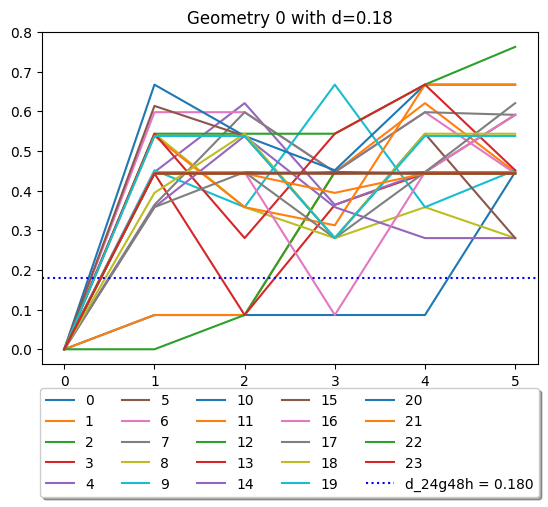

In [1458]:
geo = 0
df_distance = get_distance_wrtpath0(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

path: 1, Li: 17, distance: 0.086398880322606
path: 1, Li: 21, distance: 0.08639888032260602
path: 2, Li: 16, distance: 0.086398880322606
path: 3, Li: 0, distance: 0.086398880322606
path: 3, Li: 16, distance: 0.086398880322606


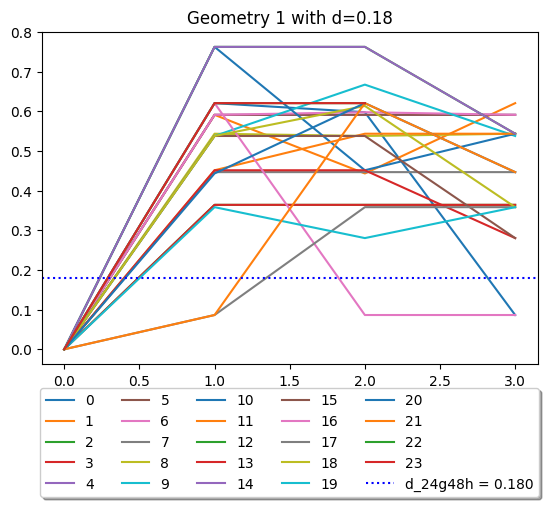

In [1459]:
geo = 1
df_distance = get_distance_wrtpath0(destination_directory, geo, max_mapping_radius, var_filename_ref, var_filename)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

## using the real algorithm

## r = 0.043

In [1460]:
max_mapping_radius = 0.09
var_filename = "mapLi_reindexed"
filename_ref_72 = "Li6PS5Cl_48n24_mod_old_2p27291_0p88814_arcA_expanded"

path: 1, Li: 0, distance: 0.0
path: 1, Li: 1, distance: 0.0
path: 1, Li: 2, distance: 0.0
path: 2, Li: 0, distance: 0.0
path: 2, Li: 1, distance: 0.0
path: 2, Li: 2, distance: 0.0
path: 2, Li: 3, distance: 0.0
path: 3, Li: 0, distance: 0.0
path: 3, Li: 16, distance: 0.0
path: 4, Li: 0, distance: 0.0


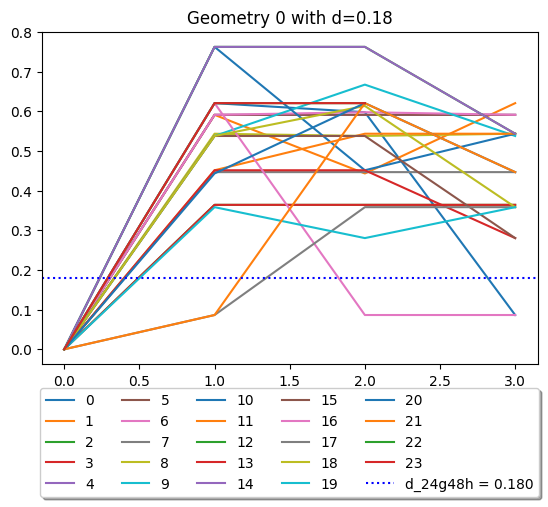

In [1461]:
geo = 0 
df_triad, df_ratio = get_distance_triads_wrtpath0(destination_directory, geo, var_filename, filename_ref_72)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

In [1462]:
df_ratio

,ratio of 48
0,0.000000
1,0.875000
2,1.000000
3,0.916667
4,1.000000
5,1.000000


In [1463]:
df_distance.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.620713,0.591239,0.364216,0.364216,0.591239,0.591239,0.591239,0.446778,0.543629,0.537924,0.762648,0.451455
2,0.597923,0.443398,0.364216,0.364216,0.591239,0.591239,0.597923,0.446778,0.537924,0.667447,0.451455,0.543629
3,0.086399,0.620713,0.364216,0.364216,0.591239,0.591239,0.591239,0.446778,0.543629,0.537924,0.543629,0.543629


In [1464]:
df_distance.iloc[:, 12:24]

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.762648,0.451455,0.762648,0.537924,0.620713,0.086399,0.537924,0.358403,0.443398,0.086399,0.620713,0.620713
2,0.762648,0.451455,0.762648,0.537924,0.086399,0.358403,0.613734,0.280397,0.620713,0.620713,0.620713,0.620713
3,0.543629,0.280397,0.543629,0.280397,0.086399,0.358403,0.358403,0.358403,0.446778,0.446778,NaN,NaN


path: 1, Li: 17, distance: 0.0
path: 1, Li: 21, distance: 0.0
path: 2, Li: 16, distance: 0.0
path: 3, Li: 0, distance: 0.0
path: 3, Li: 22, distance: 0.0


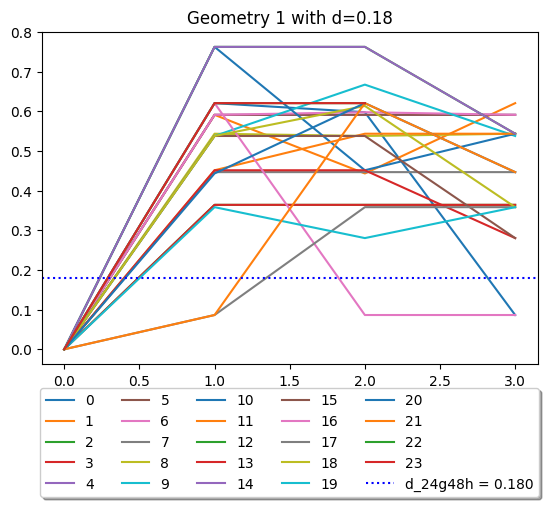

In [1465]:
geo = 1
df_triad, df_ratio = get_distance_triads_wrtpath0(destination_directory, geo, var_filename, filename_ref_72)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

In [1466]:
df_ratio

,ratio of 48
0,0.000000
1,1.000000
2,0.958333
3,1.000000


In [1467]:
df_distance.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.620713,0.591239,0.364216,0.364216,0.591239,0.591239,0.591239,0.446778,0.543629,0.537924,0.762648,0.451455
2,0.597923,0.443398,0.364216,0.364216,0.591239,0.591239,0.597923,0.446778,0.537924,0.667447,0.451455,0.543629
3,0.086399,0.620713,0.364216,0.364216,0.591239,0.591239,0.591239,0.446778,0.543629,0.537924,0.543629,0.543629


In [1468]:
df_distance.iloc[:, 12:24]

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.762648,0.451455,0.762648,0.537924,0.620713,0.086399,0.537924,0.358403,0.443398,0.086399,0.620713,0.620713
2,0.762648,0.451455,0.762648,0.537924,0.086399,0.358403,0.613734,0.280397,0.620713,0.620713,0.620713,0.620713
3,0.543629,0.280397,0.543629,0.280397,0.086399,0.358403,0.358403,0.358403,0.446778,0.446778,NaN,NaN


## idx_triad

path: 1, Li: 0, triad: 0
path: 1, Li: 1, triad: 1
path: 1, Li: 2, triad: 2
path: 2, Li: 0, triad: 0
path: 2, Li: 1, triad: 1
path: 2, Li: 2, triad: 2
path: 2, Li: 3, triad: 3
path: 3, Li: 0, triad: 0
path: 3, Li: 16, triad: 16
path: 4, Li: 0, triad: 0


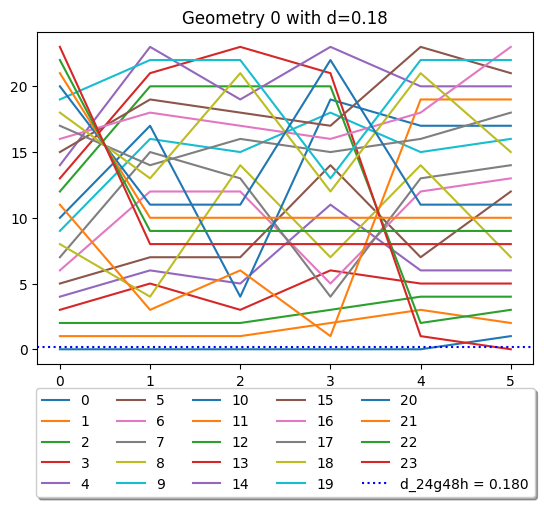

In [1469]:
geo = 0 
df_triad_0, df_ratio, df_dist, sorted_coors_Li_dist_structures = get_triads_movement(destination_directory, geo, var_filename, filename_ref_72)
plot_distance_wrtpath0(df_triad_0, geo, max_mapping_radius, Li_idxs = "all")

In [1470]:
df_ratio

,ratio of 48
0,0.000000
1,0.875000
2,1.000000
3,0.916667
4,1.000000
5,1.000000


In [1471]:
df_dist

,dist
0,"[0.3126981749898774, 0.3944086061966701, 0.312..."
1,"[0.38194757807845836, 0.34779293926127935, 0.3..."
2,"[0.38194757807845836, 0.4003497173721994, 0.42..."
3,"[0.2275611043214547, 0.38194757807845836, 0.34..."
4,"[0.2275611043214547, 0.38194757807845836, 0.34..."
5,"[0.2275611043214547, 0.38194757807845836, 0.34..."


In [1472]:
sorted_coors_Li_dist_structures

{(23, 0): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 1): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 2): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 3): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 4): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 5): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 6): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 7): {'coors': ((0.81109, 0.18891, 0.028), (0.81109, 0.18891, 0.028)),
  'dist': 0.0,
  'structures': (48, 48)},
 (23, 8): {'coors': ((0.81109, 0.18891, 0.028), (0.81109

In [1473]:
df_triad_0.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
1,0.0,1.0,2.0,5.0,6.0,7.0,12.0,15.0,4.0,16.0,17.0,3.0
2,0.0,1.0,2.0,3.0,5.0,7.0,12.0,13.0,14.0,15.0,4.0,6.0
3,0.0,2.0,3.0,6.0,11.0,14.0,5.0,4.0,7.0,18.0,19.0,1.0
4,0.0,3.0,4.0,5.0,6.0,7.0,12.0,13.0,14.0,15.0,17.0,19.0
5,1.0,2.0,4.0,5.0,6.0,12.0,13.0,14.0,7.0,16.0,17.0,19.0


In [1474]:
df_triad_0.iloc[:, 12:24]

,12,13,14,15,16,17,18,19,20,21,22,23
0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
1,20.0,21.0,23.0,19.0,18.0,14.0,13.0,22.0,11.0,10.0,9.0,8.0
2,20.0,23.0,19.0,18.0,17.0,16.0,21.0,22.0,11.0,10.0,9.0,8.0
3,20.0,21.0,23.0,17.0,16.0,15.0,12.0,13.0,22.0,10.0,9.0,8.0
4,2.0,1.0,20.0,23.0,18.0,16.0,21.0,22.0,11.0,10.0,9.0,8.0
5,3.0,0.0,20.0,21.0,23.0,18.0,15.0,22.0,11.0,10.0,9.0,8.0


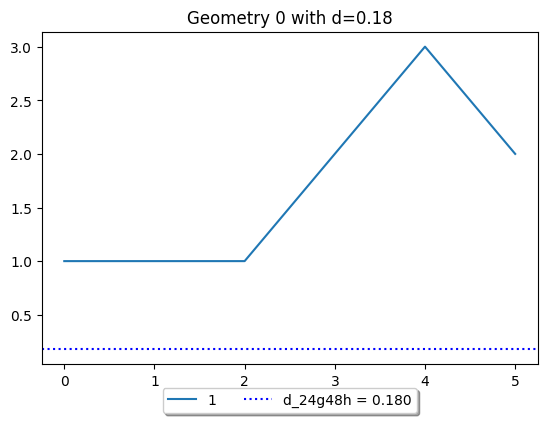

In [1475]:
plot_distance_wrtpath0(df_triad_0, geo, max_mapping_radius, Li_idxs = [1])

path: 1, Li: 17, triad: 17
path: 1, Li: 21, triad: 21
path: 2, Li: 16, triad: 16
path: 3, Li: 0, triad: 0
path: 3, Li: 22, triad: 22


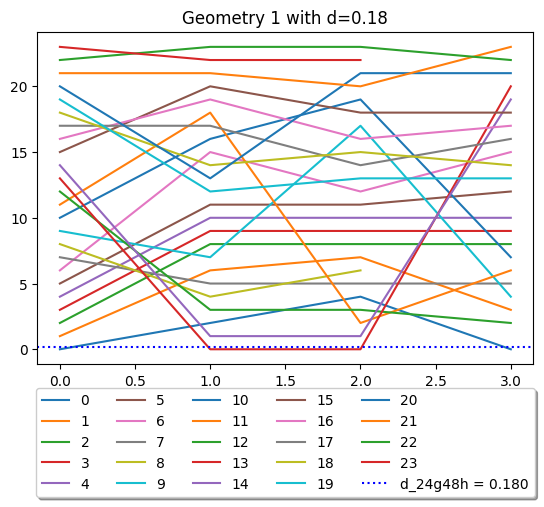

In [1476]:
geo = 1 
df_triad_1, df_ratio, df_dist, sorted_coors_Li_dist_structures = get_triads_movement(destination_directory, geo, var_filename, filename_ref_72)
plot_distance_wrtpath0(df_triad_1, geo, max_mapping_radius, Li_idxs = "all")

In [1477]:
df_ratio

,ratio of 48
0,0.000000
1,1.000000
2,0.958333
3,1.000000


In [1478]:
df_dist

,dist
0,"[0.3126981749898774, 0.3944086061966701, 0.312..."
1,"[0.2275611043214547, 0.38194757807845836, 0.34..."
2,"[0.38194757807845836, 0.44339791219738506, 0.4..."
3,"[0.38194757807845836, 0.42066605353890874, 0.3..."


In [1479]:
sorted_coors_Li_dist_structures

{(22, 0): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 1): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 2): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 3): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 4): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 5): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 6): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 7): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 0.81109, 0.31109)),
  'dist': 0.0,
  'structures': (48, 48)},
 (22, 9): {'coors': ((0.472, 0.81109, 0.31109), (0.472, 

In [1480]:
df_triad_1.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
1,2.0,6.0,8.0,9.0,10.0,11.0,15.0,5.0,4.0,7.0,16.0,18.0
2,4.0,7.0,8.0,9.0,10.0,11.0,12.0,5.0,6.0,17.0,19.0,2.0
3,0.0,3.0,8.0,9.0,10.0,12.0,15.0,5.0,NaN,4.0,7.0,6.0


In [1481]:
df_triad_1.iloc[:, 12:24]

,12,13,14,15,16,17,18,19,20,21,22,23
0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0
1,3.0,0.0,1.0,20.0,19.0,17.0,14.0,12.0,13.0,21.0,23.0,22.0
2,3.0,0.0,1.0,18.0,16.0,14.0,15.0,13.0,21.0,20.0,23.0,22.0
3,2.0,20.0,19.0,18.0,17.0,16.0,14.0,13.0,21.0,23.0,22.0,NaN


## idx_triad_normalized from starting point

In [1482]:
geo = 0

df_triad_0_normalized = df_triad_0.copy()
# for i in range(len(df_triad_0)):
for i in range(len(df_triad_0.columns)):
    init_triad = df_triad_0.iloc[0, i]
    df_triad_0_normalized.iloc[:, i] = df_triad_0_normalized.iloc[:, i] - init_triad
    # for j in range(len(df_triad_0.columns)):
    #     df_triad_0_normalized.iloc[i, j] = df_triad_0_normalized.iloc[i, j] - init_triad

In [1483]:
df_triad_0_normalized.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,2.0,2.0,2.0,6.0,8.0,-4.0,7.0,7.0,-8.0
2,0.0,0.0,0.0,0.0,1.0,2.0,6.0,6.0,6.0,6.0,-6.0,-5.0
3,0.0,1.0,1.0,3.0,7.0,9.0,-1.0,-3.0,-1.0,9.0,9.0,-10.0
4,0.0,2.0,2.0,2.0,2.0,2.0,6.0,6.0,6.0,6.0,7.0,8.0
5,1.0,1.0,2.0,2.0,2.0,7.0,7.0,7.0,-1.0,7.0,7.0,8.0


In [1484]:
df_triad_0_normalized.iloc[:, 12:24]

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8.0,8.0,9.0,4.0,2.0,-3.0,-5.0,3.0,-9.0,-11.0,-13.0,-15.0
2,8.0,10.0,5.0,3.0,1.0,-1.0,3.0,3.0,-9.0,-11.0,-13.0,-15.0
3,8.0,8.0,9.0,2.0,0.0,-2.0,-6.0,-6.0,2.0,-11.0,-13.0,-15.0
4,-10.0,-12.0,6.0,8.0,2.0,-1.0,3.0,3.0,-9.0,-11.0,-13.0,-15.0
5,-9.0,-13.0,6.0,6.0,7.0,1.0,-3.0,3.0,-9.0,-11.0,-13.0,-15.0


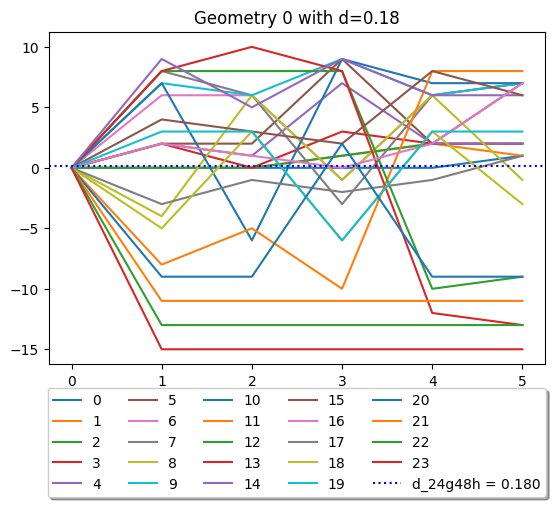

In [1485]:
plot_distance_wrtpath0(df_triad_0_normalized, geo, max_mapping_radius, Li_idxs = "all")

In [1486]:
geo = 1

df_triad_1_normalized = df_triad_1.copy()
# for i in range(len(df_triad_1)):
for i in range(len(df_triad_1.columns)):
    init_triad = df_triad_1.iloc[0, i]
    df_triad_1_normalized.iloc[:, i] = df_triad_1_normalized.iloc[:, i] - init_triad

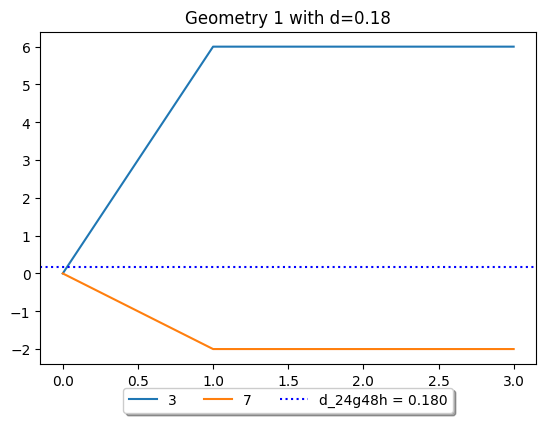

In [1487]:
plot_distance_wrtpath0(df_triad_1_normalized, geo, max_mapping_radius, Li_idxs = [3, 7])

In [1488]:
df_triad_1_normalized.iloc[:, 0:12]

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,5.0,6.0,6.0,6.0,6.0,9.0,-2.0,-4.0,-2.0,6.0,7.0
2,4.0,6.0,6.0,6.0,6.0,6.0,6.0,-2.0,-2.0,8.0,9.0,-9.0
3,0.0,2.0,6.0,6.0,6.0,7.0,9.0,-2.0,NaN,-5.0,-3.0,-5.0


In [1489]:
df_triad_1_normalized.iloc[:, 12:24]

,12,13,14,15,16,17,18,19,20,21,22,23
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-9.0,-13.0,-13.0,5.0,3.0,0.0,-4.0,-7.0,-7.0,0.0,1.0,-1.0
2,-9.0,-13.0,-13.0,3.0,0.0,-3.0,-3.0,-6.0,1.0,-1.0,1.0,-1.0
3,-10.0,7.0,5.0,3.0,1.0,-1.0,-4.0,-6.0,1.0,2.0,0.0,NaN


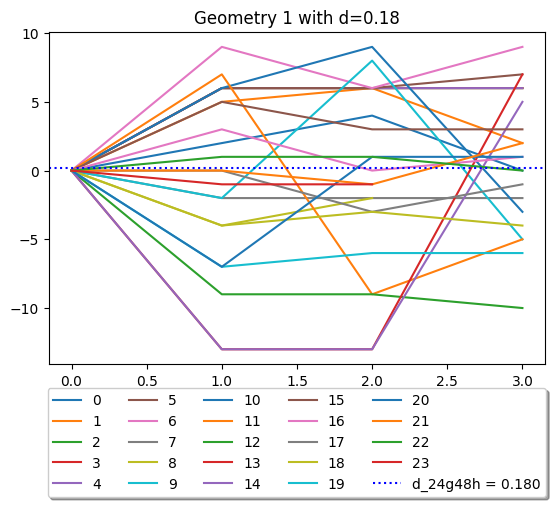

In [1490]:
plot_distance_wrtpath0(df_triad_1_normalized, geo, max_mapping_radius, Li_idxs = "all")

## r = 0.055

In [1491]:
max_mapping_radius = 0.055
destination_directory = f"restructure_{max_mapping_radius}/"
var_filename = "mapLi_reindexed"
filename_ref_72 = "Li6PS5Cl_48n24_mod_old_2p27291_0p88814_arcA_expanded"

path: 3, Li: 17, distance: 0.0
path: 5, Li: 18, distance: 0.0


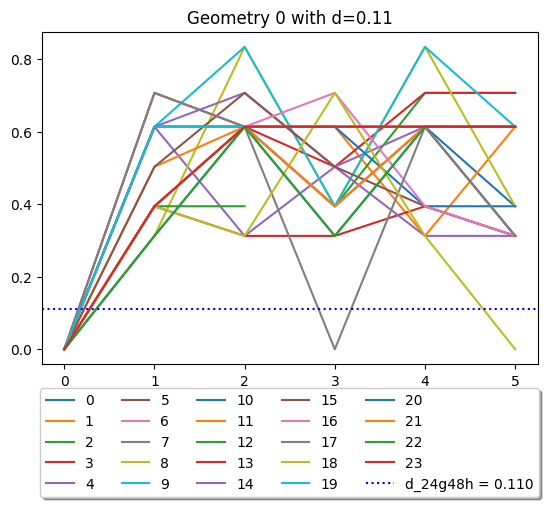

In [1492]:
geo = 0 
df_distance, df_ratio = get_distance_triads_wrtpath0(destination_directory, geo, var_filename, filename_ref_72)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

path: 1, Li: 1, distance: 0.0
path: 1, Li: 4, distance: 0.0
path: 1, Li: 5, distance: 0.0
path: 2, Li: 4, distance: 0.0
path: 2, Li: 5, distance: 0.0
path: 2, Li: 11, distance: 0.0
path: 2, Li: 18, distance: 0.0
path: 3, Li: 4, distance: 0.0
path: 3, Li: 11, distance: 0.0
path: 3, Li: 13, distance: 0.0


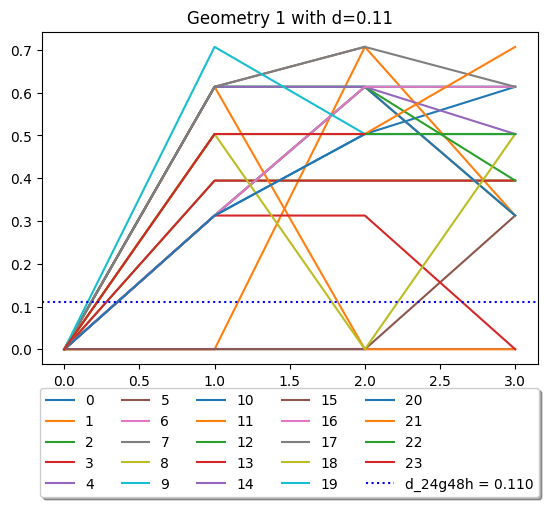

In [1493]:
geo = 1
df_distance, df_ratio = get_distance_triads_wrtpath0(destination_directory, geo, var_filename, filename_ref_72)
plot_distance_wrtpath0(df_distance, geo, max_mapping_radius, Li_idxs = "all")

## idx_triad_normalized from starting point

In [1494]:
geo = 0

df_triad_0_normalized = df_triad_0.copy()
# for i in range(len(df_triad_0)):
for i in range(len(df_triad_0.columns)):
    init_triad = df_triad_0.iloc[0, i]
    df_triad_0_normalized.iloc[:, i] = df_triad_0_normalized.iloc[:, i] - init_triad
    # for j in range(len(df_triad_0.columns)):
    #     df_triad_0_normalized.iloc[i, j] = df_triad_0_normalized.iloc[i, j] - init_triad

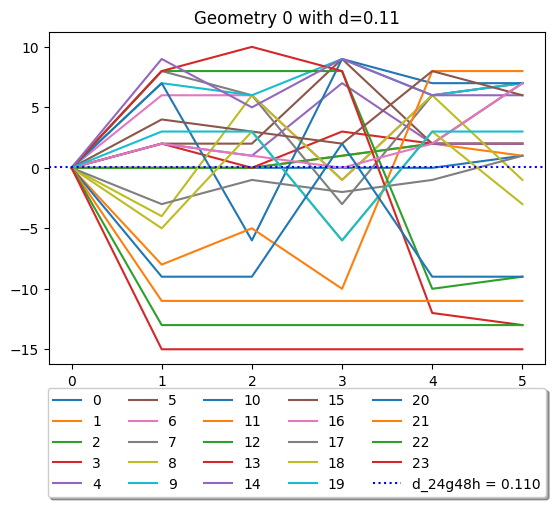

In [1495]:
plot_distance_wrtpath0(df_triad_0_normalized, geo, max_mapping_radius, Li_idxs = "all")

In [1496]:
geo = 1

df_triad_1_normalized = df_triad_1.copy()
# for i in range(len(df_triad_1)):
for i in range(len(df_triad_1.columns)):
    init_triad = df_triad_1.iloc[0, i]
    df_triad_1_normalized.iloc[:, i] = df_triad_1_normalized.iloc[:, i] - init_triad

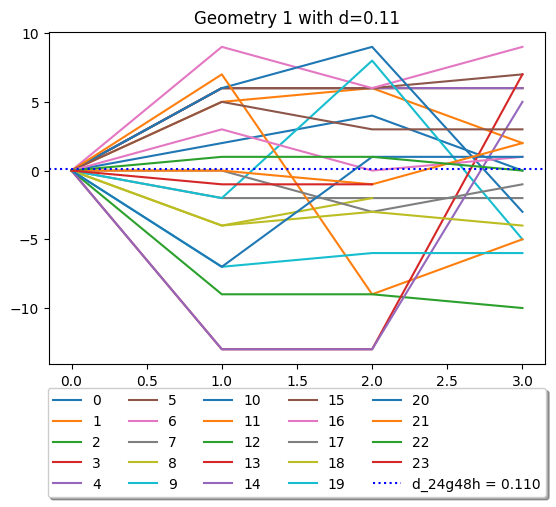

In [1497]:
plot_distance_wrtpath0(df_triad_1_normalized, geo, max_mapping_radius, Li_idxs = "all")

# Check fullness of triads

In [1498]:
# geo = 1
# max_mapping_radius = 0.1
# destination_directory = f"restructure_{max_mapping_radius}/"

# # df_idx_triad_counts = pd.DataFrame#(np.zeros((24, 1)))
# # df_idx_triad_counts["idx_triad_counts"] = None

# if geo == 0:
#     path_geo = path_geo_0
# elif geo == 1:
#     path_geo = path_geo_1
# elif geo == 2:
#     path_geo = path_geo_2
# elif geo == 3:
#     path_geo = path_geo_3
# elif geo == 4:
#     path_geo = path_geo_4
# elif geo == 5:
#     path_geo = path_geo_5
# elif geo == 6:
#     path_geo = path_geo_6
# elif geo == 7:
#     path_geo = path_geo_7
# elif geo == 8:
#     path_geo = path_geo_8

# df_idx_triad_counts = pd.DataFrame(np.zeros((24, len(path_geo))))

# file_ref_24 = f"{geo}_0_{var_filename}.cif"
# file_path_ref_24 = os.path.join(destination_directory, file_ref_24)

# file_ref_72 = f"{filename_ref_72}.cif"
# file_path_ref_72 = os.path.join(destination_directory, file_ref_72)

# idx_coor_Li_dict_ref_24 = get_idx_coor_Li_dict(file_path_ref_24)    # key is the pointer to 24
# idx_coor_Li_dict_ref_72 = get_idx_coor_Li_dict(file_path_ref_72)    # key is the pointer to 24

# idx_coor_Li_dict_ref_triad = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_ref_24, idx_coor_Li_dict_ref_72)
# # idx_coor_Li_dict_ref_24 = get_idx_coor_Li_dict(file_path_ref_24)    # key is the pointer to 24
# # idxs_Li_ref_24 = list(idx_coor_Li_dict_ref_24.keys())
# # idx_coor_Li_dict_ref_72 = get_idx_coor_Li_dict(file_path_ref_72)    # key is the pointer to 24
# # idxs_Li_ref_72 = list(idx_coor_Li_dict_ref_72.keys())

# # idx_coor_Li_dict_ref_triad = defaultdict(list)

# # for key_72, coor_72 in idx_coor_Li_dict_ref_72.items():
# #     for key_24, coor_24 in idx_coor_Li_dict_ref_24.items():
# #         distance = mic_eucledian_distance(coor_72, coor_24)
# #         if distance == 0:
# #             idx_coor_Li_dict_ref_triad[key_24].append(coor_72)

# # for key_72, coor_72 in idx_coor_Li_dict_ref_72.items():
# #     for key_24, coor_24 in idx_coor_Li_dict_ref_24.items():
# #         distance = mic_eucledian_distance(coor_72, coor_24)
# #         if distance <= 0.086399 and distance != 0:                      # to edit this number
# #             idx_coor_Li_dict_ref_triad[key_24].append(coor_72)

# # for i in path_geo:
# for i in [3]:
#     # coor_Li = []
#     file = f"{geo}_{i}_{var_filename}.cif"
#     file_path = os.path.join(destination_directory, file)

#     idx_coor_Li_dict = get_idx_coor_Li_dict(file_path)

#     file_weirdos_appended = f"{geo}_{i}_{var_filename}_weirdos_appended.cif"
#     file_path_weirdos_appended = os.path.join(destination_directory, file_weirdos_appended)

#     idx_coor_Li_dict_weirdos_appended = get_idx_coor_Li_dict(file_path_weirdos_appended)
#     # idx_coor_Li_dict_ref_triad_weirdos_appended = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_weirdos_appended, idx_coor_Li_dict_ref_72)

#     idxs_Li = list(idx_coor_Li_dict.keys())
#     idxs_Li_not = sorted(i for i in range(24) if i not in idxs_Li)

#     # # idx_coor_Li_triad_belonging_initial = defaultdict(list)
#     # # idx_coor_Li_triad_belonging_initial_centroid = defaultdict(list)

#     ### does the numeration of Li is important?
#     ### 1) check which triad it does belong to initially

#     idx_coor_Li_idx_centroid_triad_ref = get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_ref_24)
#     idx_coor_Li_idx_centroid_triad = get_idx_coor_Li_idx_centroid_triad_w_closest_dist(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict)
#     idx_coor_Li_idx_centroid_triad_weirdos_appended = get_idx_coor_Li_idx_centroid_triad_w_closest_dist_weirdos_appended(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended, idxs_Li_not)
#     # idx_coor_Li_idx_centroid_triad_weirdos_appended = get_idx_coor_Li_idx_centroid_triad_w_closest_dist(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended)
#     idxs_Li_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad.keys()]
    
#     idx_triad_array = sorted([val['idx_triad'] for val in idx_coor_Li_idx_centroid_triad.values()])
#     idx_triad_array_not = sorted(i for i in range(24) if i not in idx_triad_array)
#     # idxs_Li_triad_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad()]

#     # idx_triad_series = pd.Series(idx_triad_array)
#     # df_idx_triad_counts[i] = idx_triad_series.value_counts()

#     idx_triad_counts = defaultdict(int)
#     # Count the occurrences of each idx_triad
#     # idx_triad_counts = pd.DataFrame(np.zeros((24, 1)))
#     for key, val in idx_coor_Li_idx_centroid_triad.items():
#         idx_triad = val['idx_triad']
#         idx_triad_counts[idx_triad] += 1
#     for j in idx_triad_array_not:
#         idx_triad_counts[j] = 0

#     # df_idx_triad_counts.at[i, "idx_triad_counts"] = dict(idx_triad_counts)
#     # df_idx_triad_counts = pd.DataFrame(np.zeros((24, 1)))
#     df_idx_triad_counts[i] = dict(idx_triad_counts)
#     # df_idx_triad_counts[i].fillna(0)

In [1499]:
# geo = 1
# max_mapping_radius = 0.1
# destination_directory = f"restructure_{max_mapping_radius}/"

# # df_idx_triad_counts = pd.DataFrame#(np.zeros((24, 1)))
# # df_idx_triad_counts["idx_triad_counts"] = None

# if geo == 0:
#     path_geo = path_geo_0
# elif geo == 1:
#     path_geo = path_geo_1
# elif geo == 2:
#     path_geo = path_geo_2
# elif geo == 3:
#     path_geo = path_geo_3
# elif geo == 4:
#     path_geo = path_geo_4
# elif geo == 5:
#     path_geo = path_geo_5
# elif geo == 6:
#     path_geo = path_geo_6
# elif geo == 7:
#     path_geo = path_geo_7
# elif geo == 8:
#     path_geo = path_geo_8

# df_idx_triad_counts = pd.DataFrame(np.zeros((24, len(path_geo))))

# file_ref_24 = f"{geo}_0_{var_filename}.cif"
# file_path_ref_24 = os.path.join(destination_directory, file_ref_24)

# file_ref_72 = f"{filename_ref_72}.cif"
# file_path_ref_72 = os.path.join(destination_directory, file_ref_72)

# idx_coor_Li_dict_ref_24 = get_idx_coor_Li_dict(file_path_ref_24)    # key is the pointer to 24
# idx_coor_Li_dict_ref_72 = get_idx_coor_Li_dict(file_path_ref_72)    # key is the pointer to 24

# idx_coor_Li_dict_ref_triad = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_ref_24, idx_coor_Li_dict_ref_72)
# # idx_coor_Li_dict_ref_24 = get_idx_coor_Li_dict(file_path_ref_24)    # key is the pointer to 24
# # idxs_Li_ref_24 = list(idx_coor_Li_dict_ref_24.keys())
# # idx_coor_Li_dict_ref_72 = get_idx_coor_Li_dict(file_path_ref_72)    # key is the pointer to 24
# # idxs_Li_ref_72 = list(idx_coor_Li_dict_ref_72.keys())

# # idx_coor_Li_dict_ref_triad = defaultdict(list)

# # for key_72, coor_72 in idx_coor_Li_dict_ref_72.items():
# #     for key_24, coor_24 in idx_coor_Li_dict_ref_24.items():
# #         distance = mic_eucledian_distance(coor_72, coor_24)
# #         if distance == 0:
# #             idx_coor_Li_dict_ref_triad[key_24].append(coor_72)

# # for key_72, coor_72 in idx_coor_Li_dict_ref_72.items():
# #     for key_24, coor_24 in idx_coor_Li_dict_ref_24.items():
# #         distance = mic_eucledian_distance(coor_72, coor_24)
# #         if distance <= 0.086399 and distance != 0:                      # to edit this number
# #             idx_coor_Li_dict_ref_triad[key_24].append(coor_72)

# # for i in path_geo:
# for i in [3]:
#     # coor_Li = []
#     file = f"{geo}_{i}_{var_filename}.cif"
#     file_path = os.path.join(destination_directory, file)

#     idx_coor_Li_dict = get_idx_coor_Li_dict(file_path)

#     file_weirdos_appended = f"{geo}_{i}_{var_filename}_weirdos_appended.cif"
#     file_path_weirdos_appended = os.path.join(destination_directory, file_weirdos_appended)

#     idx_coor_Li_dict_weirdos_appended = get_idx_coor_Li_dict(file_path_weirdos_appended)
#     # idx_coor_Li_dict_ref_triad_weirdos_appended = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_weirdos_appended, idx_coor_Li_dict_ref_72)

#     idxs_Li = list(idx_coor_Li_dict.keys())
#     idxs_Li_not = sorted(i for i in range(24) if i not in idxs_Li)

#     # # idx_coor_Li_triad_belonging_initial = defaultdict(list)
#     # # idx_coor_Li_triad_belonging_initial_centroid = defaultdict(list)

#     ### does the numeration of Li is important?
#     ### 1) check which triad it does belong to initially

#     idx_coor_Li_idx_centroid_triad_ref = get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_ref_24)
#     idx_coor_Li_idx_centroid_triad = get_idx_coor_Li_idx_centroid_triad_w_closest_dist(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict)
#     idx_coor_Li_idx_centroid_triad_weirdos_appended = get_idx_coor_Li_idx_centroid_triad_w_closest_dist_weirdos_appended(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended, idxs_Li_not)
#     # idx_coor_Li_idx_centroid_triad_weirdos_appended = get_idx_coor_Li_idx_centroid_triad_w_closest_dist(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended)
#     idxs_Li_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad.keys()]
    
#     idx_triad_array = sorted([val['idx_triad'] for val in idx_coor_Li_idx_centroid_triad.values()])
#     idx_triad_array_not = sorted(i for i in range(24) if i not in idx_triad_array)
#     # idxs_Li_triad_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad()]

#     # idx_triad_series = pd.Series(idx_triad_array)
#     # df_idx_triad_counts[i] = idx_triad_series.value_counts()

#     idx_triad_counts = defaultdict(int)
#     # Count the occurrences of each idx_triad
#     # idx_triad_counts = pd.DataFrame(np.zeros((24, 1)))
#     for key, val in idx_coor_Li_idx_centroid_triad.items():
#         idx_triad = val['idx_triad']
#         idx_triad_counts[idx_triad] += 1
#     for j in idx_triad_array_not:
#         idx_triad_counts[j] = 0

#     # df_idx_triad_counts.at[i, "idx_triad_counts"] = dict(idx_triad_counts)
#     # df_idx_triad_counts = pd.DataFrame(np.zeros((24, 1)))
#     df_idx_triad_counts[i] = dict(idx_triad_counts)
#     # df_idx_triad_counts[i].fillna(0)

In [1500]:
def get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72):
    # df_idx_triad_counts = pd.DataFrame #(np.zeros((24, 1)))
    # df_idx_triad_counts["idx_triad_counts"] = None

    idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = defaultdict(list)

    if geo == 0:
        path_geo = path_geo_0
    elif geo == 1:
        path_geo = path_geo_1
    elif geo == 2:
        path_geo = path_geo_2
    elif geo == 3:
        path_geo = path_geo_3
    elif geo == 4:
        path_geo = path_geo_4
    elif geo == 5:
        path_geo = path_geo_5
    elif geo == 6:
        path_geo = path_geo_6
    elif geo == 7:
        path_geo = path_geo_7
    elif geo == 8:
        path_geo = path_geo_8

    df_idx_triad_counts = pd.DataFrame(np.zeros((24, len(path_geo))))

    file_ref_24 = f"{geo}_0_{var_filename}.cif"
    file_path_ref_24 = os.path.join(destination_directory, file_ref_24)

    file_ref_72 = f"{filename_ref_72}.cif"
    file_path_ref_72 = os.path.join(destination_directory, file_ref_72)

    idx_coor_Li_dict_ref_24 = get_idx_coor_Li_dict(file_path_ref_24)    # key is the pointer to 24
    idx_coor_Li_dict_ref_72 = get_idx_coor_Li_dict(file_path_ref_72)    # key is the pointer to 24

    idx_coor_Li_dict_ref_triad = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_ref_24, idx_coor_Li_dict_ref_72)
    # idxs_Li_ref_24 = list(idx_coor_Li_dict_ref_24.keys())
    # idxs_Li_ref_72 = list(idx_coor_Li_dict_ref_72.keys())

    for i in path_geo:
        # coor_Li = []
        file = f"{geo}_{i}_{var_filename}.cif"
        file_path = os.path.join(destination_directory, file)

        idx_coor_Li_dict = get_idx_coor_Li_dict(file_path)

        file_weirdos_appended = f"{geo}_{i}_{var_filename}_weirdos_appended.cif"
        file_path_weirdos_appended = os.path.join(destination_directory, file_weirdos_appended)

        idx_coor_Li_dict_weirdos_appended = get_idx_coor_Li_dict(file_path_weirdos_appended)
        # idx_coor_Li_dict_ref_triad_weirdos_appended = get_idx_coor_Li_dict_ref_triad(idx_coor_Li_dict_weirdos_appended, idx_coor_Li_dict_ref_72)

        idxs_Li = list(idx_coor_Li_dict.keys())
        idxs_Li_not = sorted(i for i in range(24) if i not in idxs_Li)
        # idxs_Li = list(idx_coor_Li_dict.keys())

        # # idx_coor_Li_triad_belonging_initial = defaultdict(list)
        # # idx_coor_Li_triad_belonging_initial_centroid = defaultdict(list)

        ### does the numeration of Li is important?
        ### 1) check which triad it does belong to initially

        idx_coor_Li_idx_centroid_triad_ref = get_idx_coor_Li_idx_centroid_triad(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_ref_24)
        idx_coor_Li_idx_centroid_triad = get_idx_coor_Li_idx_centroid_triad_w_closest_dist(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict)
        idx_coor_Li_idx_centroid_triad_weirdos_appended = get_idx_coor_Li_idx_centroid_triad_w_closest_dist_weirdos_appended(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended, idxs_Li_not)
        # idx_coor_Li_idx_centroid_triad_weirdos_appended = get_idx_coor_Li_idx_centroid_triad_w_closest_dist(idx_coor_Li_dict_ref_triad, idx_coor_Li_dict_weirdos_appended)
        idxs_Li_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad.keys()]
        
        idx_triad_array = sorted([val['idx_triad'] for val in idx_coor_Li_idx_centroid_triad.values()])
        idx_triad_array_not = sorted(i for i in range(24) if i not in idx_triad_array)
        # idxs_Li_triad_dict = [i for i in range(24) if i in idx_coor_Li_idx_centroid_triad()]

        # idx_triad_series = pd.Series(idx_triad_array)
        # df_idx_triad_counts[i] = idx_triad_series.value_counts()

        idx_triad_counts = defaultdict(int)
        # Count the occurrences of each idx_triad
        # idx_triad_counts = pd.DataFrame(np.zeros((24, 1)))
        for key, val in idx_coor_Li_idx_centroid_triad.items():
            idx_triad = val['idx_triad']
            idx_triad_counts[idx_triad] += 1
        for j in idx_triad_array_not:
            idx_triad_counts[j] = 0

        # df_idx_triad_counts.at[i, "idx_triad_counts"] = dict(idx_triad_counts)
        # df_idx_triad_counts = pd.DataFrame(np.zeros((24, 1)))
        df_idx_triad_counts[i] = dict(idx_triad_counts)
        # df_idx_triad_counts[i].fillna(0)

        idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[i] = dict(idx_coor_Li_idx_centroid_triad_weirdos_appended)

    return df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict

In [1501]:
def get_idxs_val(df, val):
    idxs = [(row, col) for row in range(df.shape[0]) for col in range(df.shape[1]) if df.iloc[row, col] == val]
    return idxs


def get_key_Li_idx(dict, path, idx_triad):
    idxs_li = [key for key, value in dict[path].items() if value.get('idx_triad') == idx_triad]
    return idxs_li

In [1502]:
max_mapping_radius = 0.09
destination_directory = f"restructure_{max_mapping_radius}/"
var_filename = "mapLi_reindexed"
filename_ref_72 = "Li6PS5Cl_48n24_mod_old_2p27291_0p88814_arcA_expanded"

In [1503]:
geo = 0
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1504]:
df_idx_triad_counts

,0,1,2,3,4,5
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
5,1,1,1,1,1,1
6,1,1,1,1,1,1
7,1,1,1,1,1,1
8,1,1,1,1,1,1
9,1,1,1,1,1,1


In [1505]:
idxs_0 = get_idxs_val(df_idx_triad_counts, 0)
idxs_2 = get_idxs_val(df_idx_triad_counts, 2)
print(f'idxs_0: {idxs_0}, idxs_2: {idxs_2}')

idxs_0: [], idxs_2: []


In [1506]:
geo = 1
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1507]:
df_idx_triad_counts

,0,1,2,3
0,1,1,1,1
1,1,1,1,0
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,1
8,1,1,1,1
9,1,1,1,1


In [1508]:
idxs_0 = get_idxs_val(df_idx_triad_counts, 0)
idxs_2 = get_idxs_val(df_idx_triad_counts, 2)
print(f'idxs_0: {idxs_0}, idxs_2: {idxs_2}')

idxs_0: [(1, 3), (11, 3)], idxs_2: []


In [1509]:
idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[3]

{0: {'coor': (0.31109, 0.028, 0.68891),
  'idx_triad': 0,
  'centroid_triad': (0.25, 0.028889, 0.75),
  'structure': 48},
 1: {'coor': (0.68891, 0.972, 0.68891),
  'idx_triad': 3,
  'centroid_triad': (0.75, 0.971111, 0.75),
  'structure': 48},
 2: {'coor': (0.68891, 0.31109, 0.028),
  'idx_triad': 8,
  'centroid_triad': (0.75, 0.25, 0.028889),
  'structure': 48},
 3: {'coor': (0.68891, 0.68891, 0.972),
  'idx_triad': 9,
  'centroid_triad': (0.75, 0.75, 0.971111),
  'structure': 48},
 4: {'coor': (0.31109, 0.31109, 0.972),
  'idx_triad': 10,
  'centroid_triad': (0.25, 0.25, 0.971111),
  'structure': 48},
 5: {'coor': (0.31109, 0.528, 0.18891),
  'idx_triad': 12,
  'centroid_triad': (0.25, 0.528889, 0.25),
  'structure': 48},
 6: {'coor': (0.68891, 0.472, 0.18891),
  'idx_triad': 15,
  'centroid_triad': (0.75, 0.471111, 0.25),
  'structure': 48},
 7: {'coor': (0.028, 0.18891, 0.81109),
  'idx_triad': 5,
  'centroid_triad': (0.028889, 0.25, 0.75),
  'structure': 48},
 9: {'coor': (0.028, 

In [1510]:
idxs_li_triad20 = get_key_Li_idx(idx_coor_Li_idx_centroid_triad_weirdos_appended_dict, 3, 20)
print(f'idxs_li_triad20: {idxs_li_triad20}')

idxs_li_triad20: [13]


In [1511]:
geo = 2
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1512]:
df_idx_triad_counts

,0,1,2,3,4
0,1,1,1,1,1
1,1,1,1,1,1
2,1,1,1,1,1
3,1,1,1,1,1
4,1,1,1,1,1
5,1,1,1,1,1
6,1,1,1,1,1
7,1,1,1,1,1
8,1,1,1,1,1
9,1,1,1,1,1


weird, because supposedly 2/1, 2/3 has 1 weirdo but 2/1 shows no missing ion

In [1513]:
idxs_0 = get_idxs_val(df_idx_triad_counts, 0)
idxs_2 = get_idxs_val(df_idx_triad_counts, 2)
print(f'idxs_0: {idxs_0}, idxs_2: {idxs_2}')

idxs_0: [(20, 3), (20, 4)], idxs_2: []


In [1514]:
idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[3]

{0: {'coor': (0.31109, 0.028, 0.68891),
  'idx_triad': 0,
  'centroid_triad': (0.25, 0.028889, 0.75),
  'structure': 48},
 1: {'coor': (0.25, 0.971111, 0.25),
  'idx_triad': 1,
  'centroid_triad': (0.25, 0.971111, 0.25),
  'structure': 24},
 2: {'coor': (0.68891, 0.972, 0.68891),
  'idx_triad': 3,
  'centroid_triad': (0.75, 0.971111, 0.75),
  'structure': 48},
 3: {'coor': (0.028, 0.68891, 0.31109),
  'idx_triad': 4,
  'centroid_triad': (0.028889, 0.75, 0.25),
  'structure': 48},
 4: {'coor': (0.971111, 0.75, 0.75),
  'idx_triad': 6,
  'centroid_triad': (0.971111, 0.75, 0.75),
  'structure': 24},
 5: {'coor': (0.971111, 0.25, 0.25),
  'idx_triad': 7,
  'centroid_triad': (0.971111, 0.25, 0.25),
  'structure': 24},
 6: {'coor': (0.68891, 0.31109, 0.028),
  'idx_triad': 8,
  'centroid_triad': (0.75, 0.25, 0.028889),
  'structure': 48},
 7: {'coor': (0.68891, 0.472, 0.18891),
  'idx_triad': 15,
  'centroid_triad': (0.75, 0.471111, 0.25),
  'structure': 48},
 8: {'coor': (0.028, 0.18891, 0.

In [1515]:
idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[4]

{0: {'coor': (0.31109, 0.972, 0.31109),
  'idx_triad': 1,
  'centroid_triad': (0.25, 0.971111, 0.25),
  'structure': 48},
 1: {'coor': (0.68891, 0.028, 0.31109),
  'idx_triad': 2,
  'centroid_triad': (0.75, 0.028889, 0.25),
  'structure': 48},
 2: {'coor': (0.68891, 0.972, 0.68891),
  'idx_triad': 3,
  'centroid_triad': (0.75, 0.971111, 0.75),
  'structure': 48},
 3: {'coor': (0.028, 0.31109, 0.68891),
  'idx_triad': 5,
  'centroid_triad': (0.028889, 0.25, 0.75),
  'structure': 48},
 4: {'coor': (0.971111, 0.75, 0.75),
  'idx_triad': 6,
  'centroid_triad': (0.971111, 0.75, 0.75),
  'structure': 24},
 5: {'coor': (0.028, 0.81109, 0.18891),
  'idx_triad': 4,
  'centroid_triad': (0.028889, 0.75, 0.25),
  'structure': 48},
 6: {'coor': (0.68891, 0.81109, 0.528),
  'idx_triad': 16,
  'centroid_triad': (0.75, 0.75, 0.528889),
  'structure': 48},
 7: {'coor': (0.68891, 0.18891, 0.472),
  'idx_triad': 17,
  'centroid_triad': (0.75, 0.25, 0.471111),
  'structure': 48},
 8: {'coor': (0.31109, 0.

In [1516]:
idxs_li_triad20 = get_key_Li_idx(idx_coor_Li_idx_centroid_triad_weirdos_appended_dict, 3, 20)
print(f'idxs_li_triad20: {idxs_li_triad20}')

idxs_li_triad20: []


In [1517]:
geo = 3
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1518]:
df_idx_triad_counts

,0,1,2,3,4,5,6,7
0,1,1,1,1,0,0,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1


3/5 shows 3 missing atoms

In [1519]:
idxs_0 = get_idxs_val(df_idx_triad_counts, 0)
idxs_2 = get_idxs_val(df_idx_triad_counts, 2)
print(f'idxs_0: {idxs_0}, idxs_2: {idxs_2}')

idxs_0: [(0, 4), (0, 5), (13, 5), (23, 3), (23, 5), (23, 7)], idxs_2: [(20, 3), (20, 7)]


In [1520]:
idxs_li_triad20 = get_key_Li_idx(idx_coor_Li_idx_centroid_triad_weirdos_appended_dict, 3, 20)
print(f'idxs_li_triad20: {idxs_li_triad20}')

idxs_li_triad20: [9, 18]


In [1521]:
idxs_li_triad20 = get_key_Li_idx(idx_coor_Li_idx_centroid_triad_weirdos_appended_dict, 4, 13)
print(f'idxs_li_triad20: {idxs_li_triad20}')

idxs_li_triad20: [17]


In [1522]:
idxs_li_triad20 = get_key_Li_idx(idx_coor_Li_idx_centroid_triad_weirdos_appended_dict, 7, 20)
print(f'idxs_li_triad20: {idxs_li_triad20}')

idxs_li_triad20: [9, 19]


In [1523]:
idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[3]

{0: {'coor': (0.75, 0.971111, 0.75),
  'idx_triad': 3,
  'centroid_triad': (0.75, 0.971111, 0.75),
  'structure': 24},
 1: {'coor': (0.028889, 0.75, 0.25),
  'idx_triad': 4,
  'centroid_triad': (0.028889, 0.75, 0.25),
  'structure': 24},
 2: {'coor': (0.028889, 0.25, 0.75),
  'idx_triad': 5,
  'centroid_triad': (0.028889, 0.25, 0.75),
  'structure': 24},
 3: {'coor': (0.971111, 0.75, 0.75),
  'idx_triad': 6,
  'centroid_triad': (0.971111, 0.75, 0.75),
  'structure': 24},
 4: {'coor': (0.971111, 0.25, 0.25),
  'idx_triad': 7,
  'centroid_triad': (0.971111, 0.25, 0.25),
  'structure': 24},
 5: {'coor': (0.75, 0.528889, 0.75),
  'idx_triad': 14,
  'centroid_triad': (0.75, 0.528889, 0.75),
  'structure': 24},
 6: {'coor': (0.75, 0.028889, 0.25),
  'idx_triad': 2,
  'centroid_triad': (0.75, 0.028889, 0.25),
  'structure': 24},
 7: {'coor': (0.25, 0.028889, 0.75),
  'idx_triad': 0,
  'centroid_triad': (0.25, 0.028889, 0.75),
  'structure': 24},
 8: {'coor': (0.25, 0.971111, 0.25),
  'idx_tri

In [1524]:
idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[4]

{0: {'coor': (0.31109, 0.972, 0.31109),
  'idx_triad': 1,
  'centroid_triad': (0.25, 0.971111, 0.25),
  'structure': 48},
 1: {'coor': (0.028, 0.68891, 0.31109),
  'idx_triad': 4,
  'centroid_triad': (0.028889, 0.75, 0.25),
  'structure': 48},
 2: {'coor': (0.972, 0.68891, 0.68891),
  'idx_triad': 6,
  'centroid_triad': (0.971111, 0.75, 0.75),
  'structure': 48},
 3: {'coor': (0.68891, 0.31109, 0.028),
  'idx_triad': 8,
  'centroid_triad': (0.75, 0.25, 0.028889),
  'structure': 48},
 4: {'coor': (0.68891, 0.68891, 0.972),
  'idx_triad': 9,
  'centroid_triad': (0.75, 0.75, 0.971111),
  'structure': 48},
 5: {'coor': (0.68891, 0.528, 0.81109),
  'idx_triad': 14,
  'centroid_triad': (0.75, 0.528889, 0.75),
  'structure': 48},
 6: {'coor': (0.75, 0.471111, 0.25),
  'idx_triad': 15,
  'centroid_triad': (0.75, 0.471111, 0.25),
  'structure': 24},
 7: {'coor': (0.028, 0.18891, 0.81109),
  'idx_triad': 5,
  'centroid_triad': (0.028889, 0.25, 0.75),
  'structure': 48},
 8: {'coor': (0.972, 0.18

In [1525]:
idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[5]

{0: {'coor': (0.31109, 0.972, 0.31109),
  'idx_triad': 1,
  'centroid_triad': (0.25, 0.971111, 0.25),
  'structure': 48},
 1: {'coor': (0.028889, 0.75, 0.25),
  'idx_triad': 4,
  'centroid_triad': (0.028889, 0.75, 0.25),
  'structure': 24},
 2: {'coor': (0.028889, 0.25, 0.75),
  'idx_triad': 5,
  'centroid_triad': (0.028889, 0.25, 0.75),
  'structure': 24},
 3: {'coor': (0.971111, 0.75, 0.75),
  'idx_triad': 6,
  'centroid_triad': (0.971111, 0.75, 0.75),
  'structure': 24},
 4: {'coor': (0.971111, 0.25, 0.25),
  'idx_triad': 7,
  'centroid_triad': (0.971111, 0.25, 0.25),
  'structure': 24},
 5: {'coor': (0.68891, 0.31109, 0.028),
  'idx_triad': 8,
  'centroid_triad': (0.75, 0.25, 0.028889),
  'structure': 48},
 6: {'coor': (0.31109, 0.68891, 0.028),
  'idx_triad': 11,
  'centroid_triad': (0.25, 0.75, 0.028889),
  'structure': 48},
 7: {'coor': (0.31109, 0.528, 0.18891),
  'idx_triad': 12,
  'centroid_triad': (0.25, 0.528889, 0.25),
  'structure': 48},
 8: {'coor': (0.68891, 0.18891, 0.

In [1526]:
idx_coor_Li_idx_centroid_triad_weirdos_appended_dict[7]

{0: {'coor': (0.75, 0.971111, 0.75),
  'idx_triad': 3,
  'centroid_triad': (0.75, 0.971111, 0.75),
  'structure': 24},
 1: {'coor': (0.028889, 0.75, 0.25),
  'idx_triad': 4,
  'centroid_triad': (0.028889, 0.75, 0.25),
  'structure': 24},
 2: {'coor': (0.028889, 0.25, 0.75),
  'idx_triad': 5,
  'centroid_triad': (0.028889, 0.25, 0.75),
  'structure': 24},
 3: {'coor': (0.971111, 0.75, 0.75),
  'idx_triad': 6,
  'centroid_triad': (0.971111, 0.75, 0.75),
  'structure': 24},
 4: {'coor': (0.971111, 0.25, 0.25),
  'idx_triad': 7,
  'centroid_triad': (0.971111, 0.25, 0.25),
  'structure': 24},
 5: {'coor': (0.75, 0.528889, 0.75),
  'idx_triad': 14,
  'centroid_triad': (0.75, 0.528889, 0.75),
  'structure': 24},
 6: {'coor': (0.75, 0.028889, 0.25),
  'idx_triad': 2,
  'centroid_triad': (0.75, 0.028889, 0.25),
  'structure': 24},
 7: {'coor': (0.25, 0.028889, 0.75),
  'idx_triad': 0,
  'centroid_triad': (0.25, 0.028889, 0.75),
  'structure': 24},
 8: {'coor': (0.25, 0.971111, 0.25),
  'idx_tri

In [1527]:
geo = 4
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1528]:
df_idx_triad_counts

,0,1,2,3,4,5
0,1,1,1,1,1,1
1,1,1,1,1,1,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1
5,1,1,1,1,1,1
6,1,1,1,1,1,1
7,1,1,1,1,1,2
8,1,1,1,1,1,1
9,1,1,1,1,1,1


In [1529]:
geo = 5
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1530]:
df_idx_triad_counts

,0,1,2,3,4,5,6,7
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1


In [1531]:
geo = 6
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1532]:
df_idx_triad_counts

,0,1,2,3,4,5,6,7
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,0,1
6,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1


In [1533]:
geo = 7
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1534]:
df_idx_triad_counts

,0,1,2,3,4,5
0,1,1,1,0,0,0
1,1,1,1,1,1,1
2,1,1,1,1,1,2
3,1,1,1,1,1,1
4,1,1,0,1,1,1
5,1,1,1,1,1,1
6,1,1,1,1,1,1
7,1,1,1,1,1,1
8,1,1,1,1,1,1
9,1,1,1,1,1,1


In [1535]:
geo = 8
df_idx_triad_counts, idx_coor_Li_idx_centroid_triad_weirdos_appended_dict = get_triads_fullness(destination_directory, geo, var_filename, filename_ref_72)

In [1536]:
df_idx_triad_counts

,0,1,2,3
0,1,1,1,1
1,1,1,1,0
2,1,1,1,1
3,1,1,1,1
4,1,1,2,0
5,1,1,1,1
6,1,1,1,1
7,1,1,1,1
8,1,1,1,1
9,1,1,1,1
